<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Variational_autoencoders_credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 09th Nov, 2023
#               Orig: VijayDashmi
# Ref: https://www.kaggle.com/code/hone5com/fraud-detection-with-variational-autoencoder

# Variational Autoencoder

In [ ]:
# 0.0
%reset -f

In [1]:
# 1.0 Python ≥3.5 is required

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler


# 1.0.2 TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1.0.3 Common imports
import numpy as np
import pandas as pd
import os,time


# 1.0.4 To plot pretty figures
import matplotlib.pyplot as plt

In [2]:
# 1.0.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# 2.0
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# 2.1
pathToFolder= "/gdrive/MyDrive/Colab_data_files/creditcard/"
file = "creditcardfraud.zip"

In [5]:
# 2.2 Read file:
raw_data = pd.read_csv(pathToFolder + file)
raw_data.shape  # (284807, 31)

(284807, 31)

In [6]:
# 2.3
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Some rough work

In [ ]:
# Time appears to be in seconds:

raw_data['Time'].max()  # 172792.0

In [14]:
x = 3700/3600 % 24
x   # Converts to hours scale 1.0277777777777777

1.0277777777777777

In [17]:
x = ((12 * 3600) + 100)
x

43300

In [19]:
x/3600 %24   # 12.027777777777779

12.027777777777779

## Split data

In [12]:
# 3.0
data, data_test = train_test_split(raw_data,
                                   test_size=0.25
                                   )

We transform the Time field to time-of-day to account for intraday seasonality. The Amount field is transformed to log scale, with the intuition that the scale of magnitute of a transaction could be a more relevant feature for fraud than linear amounts.

### What is lambda

In [ ]:
# 3.0.1
str = "abc d"
upper = lambda string: string.upper()
upper(str)

In [ ]:
# 3.0.2
mul = lambda a,b: a * b
mul(4,5)

In [20]:
# 3.1
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

# 3.1.1
data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33989,10.406667,1.048966,-0.096660,1.461295,1.839049,-0.916210,0.307238,-0.491148,0.221729,1.136095,...,-0.376538,-0.577020,0.146884,0.628095,0.373787,-0.544092,0.096037,0.034710,2.128232,0
49236,12.213611,1.116449,-0.211269,0.754197,0.517043,-0.552102,0.145750,-0.494253,0.133863,0.512614,...,0.022080,0.009849,-0.022585,-0.444430,0.154436,0.344100,0.007993,0.027677,4.020698,0
106609,19.453889,-0.830733,1.356850,0.923871,-0.370863,0.343035,-0.320716,0.755692,-0.024482,-0.035177,...,-0.355895,-0.769711,-0.085675,-0.633937,0.075293,0.143074,0.490865,0.231209,2.781920,0
18319,8.161944,1.277616,0.008527,-1.154306,0.258949,2.193753,3.604186,-0.448926,0.851078,0.173330,...,-0.187916,-0.476908,-0.120082,1.009497,0.895922,-0.325840,0.026738,0.011169,0.693147,0
246394,18.543611,-0.961426,1.484112,-0.687170,-0.282980,1.126348,0.242898,0.469845,0.318000,-0.719651,...,-0.159002,-0.664890,-0.001695,-0.273869,-0.479963,0.291629,-0.541864,0.122786,0.636577,0


In [21]:
# 3.2
x = data.drop(["Class"], axis=1)
y = data["Class"].values


In [22]:
# 3.3 Transform x to numpy and then
#     separate normal vs fraud data:

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]



In [23]:
x_norm.shape

(213230, 30)

In [24]:
# 3.4 Sample normal data to size 100000:

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]


In [25]:
# 3.5 Split sample into train/validation:

x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample,
                                                          test_size=0.2
                                                          )

In [26]:
# 5.2 Calculate accuracy:

def rounded_accuracy(y_true, y_pred):
    # tf.round(x) rounds the values of x to integer values.
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Given y, I can take a log of it as: log$_{10}$y. Let us say this log is z. Then,  
z = log$_{10}$y  
To get y back from z, I have to raise 10 to the power of z, ie:  
10$^{z}$  ie y = 10$^{z}$  OR log$_{10}$y = z

Therefore, exp(log_var / 2) will give (exp(log σ$^{2}))$$^{0.5}$ or just (σ$^{2}$)$^{0.5}$ or just σ.

## Sampling layer

(log_var / 2) is same as (2* log(sigma) / 2 ) or log(sigma)   
Therefore, exp(log(sigma)) is sigma



In [27]:
# 4.0 Sampling layer
# tf.random_normal: https://www.tensorflow.org/api_docs/python/tf/random/normal

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        out = tf.keras.backend.random_normal(
                                              shape = tf.shape(log_var)   # Output random values of given shape
                                                                          #  with mean 0 and stdev 1
                                             )
        out = out * tf.keras.backend.exp(log_var / 2) + mean    # Z * σ + mean
        return out

In [28]:
# 4.1 latent space size:
codings_size = 2

## Encoder

In [29]:
# 4.2 encoder

inputs = tf.keras.layers.Input(shape=[x.shape[1]])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(20,
                       activation="selu")(z)

z = tf.keras.layers.Dense(10,
                       activation="selu")(z)

z = tf.keras.layers.Dense(8,
                       activation="selu")(z)

In [30]:
# 4.2.1 Encoder has two outputs:

codings_mean = tf.keras.layers.Dense(codings_size)(z)
codings_log_var = tf.keras.layers.Dense(codings_size)(z)

In [31]:
# 4.2.2 And also a IIIRd one derived from above two:

codings = Sampling()([codings_mean, codings_log_var])

In [32]:
# 4.3 Create encoder. But it outputs three tensors
#     'codings_mean', 'codings_log_var', 'codings'
#     though in the deocder only 'codings' tensor
#     is used.

variational_encoder = tf.keras.models.Model(
                                          inputs=[inputs],
                                          outputs=[codings_mean, codings_log_var, codings]
                                          )

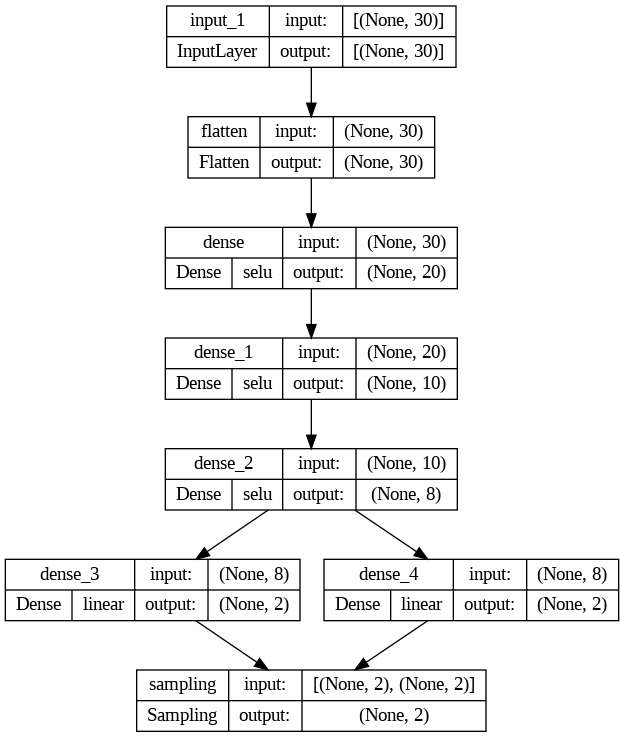

In [33]:
# 4.4 Plot the encoder model:

tf.keras.utils.plot_model(variational_encoder,
                          show_shapes=True,
                          show_layer_activations=True
                          )

## Decoder model

In [34]:
# 5.0 For decoder the only input is codings:

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(10, activation="selu")(decoder_inputs)
x = tf.keras.layers.Dense(20, activation="selu")(x)
x = tf.keras.layers.Dense(30, activation="selu")(x)
outputs = x


In [35]:
# 5.1 Our decoder:
variational_decoder = tf.keras.models.Model(
                                          inputs=[decoder_inputs],
                                          outputs=[outputs]
                                          )


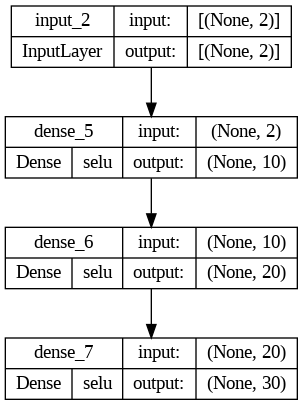

In [36]:
# 5.2 Decoder plot
tf.keras.utils.plot_model(variational_decoder,
                          show_shapes = True,
                          show_layer_activations=True
                          )

## Variational encoder

In [37]:
# 6.0 Get decoder output:

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)


In [38]:
# 6.1
variational_ae = tf.keras.models.Model(
                                    inputs=[inputs],
                                    outputs=[reconstructions]
                                    )

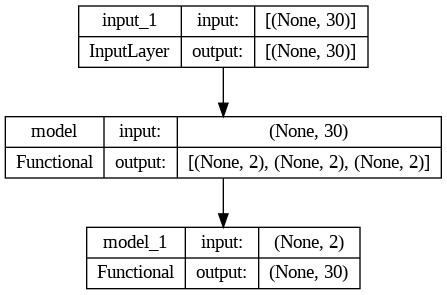

In [39]:
# 6.2
tf.keras.utils.plot_model(
                          variational_ae,
                          show_shapes= True,
                          show_layer_activations= True
                          )

## Latent loss

In [40]:
# 7.0 Latent loss is the sum of cross-entropy loss and KL divergence:

latent_loss = -0.5 * tf.keras.backend.sum(
                           1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis=-1
                           )

In [41]:
# 7.1 Add latent loss during compile time:
variational_ae.add_loss(
                         tf.keras.backend.mean(latent_loss) / 30.
                        )

In [42]:
# 7.2
variational_ae.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=[rounded_accuracy]
                       )

In [48]:
# Repeat 7.2.1
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [45]:
x_norm_train_sample.shape
x_norm_val_sample.shape

(80000, 30)

(20000, 30)

In [46]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
                                                  filepath='bestmodel.h5',
                                                  verbose=0,
                                                  save_best_only=True
                                                 )

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                mode='min',
                                                min_delta=0.005,
                                                patience=20, verbose=0,
                                                restore_best_weights=True
                                                )

In [49]:
start = time.time()
history = variational_ae.fit(x_norm_train_sample,
                             x_norm_train_sample,
                             epochs= 100, #  1000,
                             batch_size=128,
                             callbacks=[checkpointer, earlystopper],
                             validation_data=(x_norm_val_sample, x_norm_val_sample)
                             )

end = time.time()
print((end-start)/60)

Epoch 1/100
605/625 [============================>.] - ETA: 0s - loss: -3.4130 - rounded_accuracy: 0.5106

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 4s 5ms/step - loss: -3.5712 - rounded_accuracy: 0.5109 - val_loss: -8.3125 - val_rounded_accuracy: 0.5210
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: -8.5335 - rounded_accuracy: 0.5214

625/625 [==============================] - 6s 10ms/step - loss: -8.5335 - rounded_accuracy: 0.5214 - val_loss: -8.6466 - val_rounded_accuracy: 0.5257
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: -8.8453 - rounded_accuracy: 0.5247

625/625 [==============================] - 2s 4ms/step - loss: -8.8453 - rounded_accuracy: 0.5247 - val_loss: -9.0716 - val_rounded_accuracy: 0.5287
Epoch 4/100
622/625 [============================>.] - ETA: 0s - loss: -9.1610 - rounded_accuracy: 0.5272

625/625 [==============================] - 2s 4ms/step - loss: -9.1595 - rounded_accuracy: 0.5272 - val_loss: -9.2751 - val_rounded_accuracy: 0.5298
Epoch 5/100
619/625 [============================>.] - ETA: 0s - loss: -9.3061 - rounded_accuracy: 0.5286

625/625 [==============================] - 2s 3ms/step - loss: -9.3050 - rounded_accuracy: 0.5286 - val_loss: -9.3864 - val_rounded_accuracy: 0.5310
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: -9.4400 - rounded_accuracy: 0.5297 - val_loss: -9.3855 - val_rounded_accuracy: 0.5301
Epoch 7/100
625/625 [==============================] - ETA: 0s - loss: -9.4834 - rounded_accuracy: 0.5297

625/625 [==============================] - 2s 3ms/step - loss: -9.4834 - rounded_accuracy: 0.5297 - val_loss: -9.5598 - val_rounded_accuracy: 0.5314
Epoch 8/100
625/625 [==============================] - 3s 5ms/step - loss: -9.5667 - rounded_accuracy: 0.5290 - val_loss: -9.4840 - val_rounded_accuracy: 0.5269
Epoch 9/100
625/625 [==============================] - 3s 4ms/step - loss: -9.6056 - rounded_accuracy: 0.5294 - val_loss: -9.4789 - val_rounded_accuracy: 0.5276
Epoch 10/100
620/625 [============================>.] - ETA: 0s - loss: -9.6473 - rounded_accuracy: 0.5294

625/625 [==============================] - 2s 4ms/step - loss: -9.6480 - rounded_accuracy: 0.5294 - val_loss: -9.6064 - val_rounded_accuracy: 0.5312
Epoch 11/100
614/625 [============================>.] - ETA: 0s - loss: -9.6638 - rounded_accuracy: 0.5301

625/625 [==============================] - 2s 3ms/step - loss: -9.6674 - rounded_accuracy: 0.5300 - val_loss: -9.7123 - val_rounded_accuracy: 0.5314
Epoch 12/100
625/625 [==============================] - 2s 3ms/step - loss: -9.6934 - rounded_accuracy: 0.5294 - val_loss: -9.5482 - val_rounded_accuracy: 0.5285
Epoch 13/100
618/625 [============================>.] - ETA: 0s - loss: -9.7571 - rounded_accuracy: 0.5312

625/625 [==============================] - 2s 3ms/step - loss: -9.7580 - rounded_accuracy: 0.5312 - val_loss: -9.7494 - val_rounded_accuracy: 0.5315
Epoch 14/100
620/625 [============================>.] - ETA: 0s - loss: -9.7530 - rounded_accuracy: 0.5310

625/625 [==============================] - 3s 5ms/step - loss: -9.7551 - rounded_accuracy: 0.5310 - val_loss: -9.7779 - val_rounded_accuracy: 0.5338
Epoch 15/100
620/625 [============================>.] - ETA: 0s - loss: -9.7965 - rounded_accuracy: 0.5311

625/625 [==============================] - 3s 4ms/step - loss: -9.7959 - rounded_accuracy: 0.5311 - val_loss: -9.7912 - val_rounded_accuracy: 0.5331
Epoch 16/100
625/625 [==============================] - 3s 6ms/step - loss: -9.8245 - rounded_accuracy: 0.5320 - val_loss: -9.6483 - val_rounded_accuracy: 0.5320
Epoch 17/100
621/625 [============================>.] - ETA: 0s - loss: -9.8391 - rounded_accuracy: 0.5318

625/625 [==============================] - 2s 3ms/step - loss: -9.8395 - rounded_accuracy: 0.5318 - val_loss: -9.8405 - val_rounded_accuracy: 0.5345
Epoch 18/100
621/625 [============================>.] - ETA: 0s - loss: -9.8463 - rounded_accuracy: 0.5314

625/625 [==============================] - 2s 4ms/step - loss: -9.8481 - rounded_accuracy: 0.5314 - val_loss: -9.8868 - val_rounded_accuracy: 0.5337
Epoch 19/100
625/625 [==============================] - 3s 5ms/step - loss: -9.8756 - rounded_accuracy: 0.5327 - val_loss: -9.8309 - val_rounded_accuracy: 0.5352
Epoch 20/100
625/625 [==============================] - 3s 5ms/step - loss: -9.9059 - rounded_accuracy: 0.5327 - val_loss: -9.8796 - val_rounded_accuracy: 0.5348
Epoch 21/100
625/625 [==============================] - 2s 3ms/step - loss: -9.9329 - rounded_accuracy: 0.5325 - val_loss: -9.8857 - val_rounded_accuracy: 0.5335
Epoch 22/100
618/625 [============================>.] - ETA: 0s - loss: -9.9240 - rounded_accuracy: 0.5329

625/625 [==============================] - 2s 3ms/step - loss: -9.9268 - rounded_accuracy: 0.5329 - val_loss: -9.9364 - val_rounded_accuracy: 0.5346
Epoch 23/100
622/625 [============================>.] - ETA: 0s - loss: -9.9672 - rounded_accuracy: 0.5330

625/625 [==============================] - 2s 3ms/step - loss: -9.9683 - rounded_accuracy: 0.5330 - val_loss: -9.9660 - val_rounded_accuracy: 0.5338
Epoch 24/100
625/625 [==============================] - 2s 3ms/step - loss: -9.9746 - rounded_accuracy: 0.5329 - val_loss: -9.9240 - val_rounded_accuracy: 0.5328
Epoch 25/100
625/625 [==============================] - 3s 4ms/step - loss: -9.9897 - rounded_accuracy: 0.5327 - val_loss: -9.9424 - val_rounded_accuracy: 0.5339
Epoch 26/100
625/625 [==============================] - 3s 5ms/step - loss: -10.0157 - rounded_accuracy: 0.5333 - val_loss: -9.9503 - val_rounded_accuracy: 0.5345
Epoch 27/100
612/625 [============================>.] - ETA: 0s - loss: -10.0066 - rounded_accuracy: 0.5325

625/625 [==============================] - 2s 3ms/step - loss: -10.0064 - rounded_accuracy: 0.5325 - val_loss: -9.9986 - val_rounded_accuracy: 0.5335
Epoch 28/100
625/625 [==============================] - 2s 3ms/step - loss: -10.0175 - rounded_accuracy: 0.5331 - val_loss: -9.8371 - val_rounded_accuracy: 0.5333
Epoch 29/100
625/625 [==============================] - 2s 3ms/step - loss: -10.0360 - rounded_accuracy: 0.5327 - val_loss: -9.9895 - val_rounded_accuracy: 0.5342
Epoch 30/100
625/625 [==============================] - 2s 3ms/step - loss: -10.0331 - rounded_accuracy: 0.5330 - val_loss: -9.8575 - val_rounded_accuracy: 0.5327
Epoch 31/100
620/625 [============================>.] - ETA: 0s - loss: -10.0426 - rounded_accuracy: 0.5327

625/625 [==============================] - 3s 4ms/step - loss: -10.0417 - rounded_accuracy: 0.5328 - val_loss: -10.0560 - val_rounded_accuracy: 0.5330
Epoch 32/100
620/625 [============================>.] - ETA: 0s - loss: -10.0764 - rounded_accuracy: 0.5327

625/625 [==============================] - 3s 5ms/step - loss: -10.0776 - rounded_accuracy: 0.5328 - val_loss: -10.1208 - val_rounded_accuracy: 0.5346
Epoch 33/100
625/625 [==============================] - 2s 3ms/step - loss: -10.0746 - rounded_accuracy: 0.5336 - val_loss: -10.0053 - val_rounded_accuracy: 0.5332
Epoch 34/100
625/625 [==============================] - 2s 3ms/step - loss: -10.0871 - rounded_accuracy: 0.5333 - val_loss: -10.0957 - val_rounded_accuracy: 0.5347
Epoch 35/100
608/625 [============================>.] - ETA: 0s - loss: -10.1133 - rounded_accuracy: 0.5324

625/625 [==============================] - 2s 3ms/step - loss: -10.1120 - rounded_accuracy: 0.5326 - val_loss: -10.1456 - val_rounded_accuracy: 0.5342
Epoch 36/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1190 - rounded_accuracy: 0.5327 - val_loss: -10.1122 - val_rounded_accuracy: 0.5344
Epoch 37/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1250 - rounded_accuracy: 0.5338 - val_loss: -10.0516 - val_rounded_accuracy: 0.5327
Epoch 38/100
625/625 [==============================] - 3s 5ms/step - loss: -10.0986 - rounded_accuracy: 0.5332 - val_loss: -10.0699 - val_rounded_accuracy: 0.5344
Epoch 39/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1329 - rounded_accuracy: 0.5339 - val_loss: -10.0863 - val_rounded_accuracy: 0.5344
Epoch 40/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1403 - rounded_accuracy: 0.5344 - val_loss: -10.1310 - val_rounded_accuracy: 0.5358
Epoch 41/100
625/625 [=======

625/625 [==============================] - 2s 4ms/step - loss: -10.1290 - rounded_accuracy: 0.5348 - val_loss: -10.1602 - val_rounded_accuracy: 0.5366
Epoch 44/100
616/625 [============================>.] - ETA: 0s - loss: -10.1606 - rounded_accuracy: 0.5349

625/625 [==============================] - 4s 6ms/step - loss: -10.1629 - rounded_accuracy: 0.5349 - val_loss: -10.1766 - val_rounded_accuracy: 0.5351
Epoch 45/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1629 - rounded_accuracy: 0.5339 - val_loss: -10.0985 - val_rounded_accuracy: 0.5330
Epoch 46/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1677 - rounded_accuracy: 0.5348 - val_loss: -10.1486 - val_rounded_accuracy: 0.5352
Epoch 47/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1877 - rounded_accuracy: 0.5354 - val_loss: -10.1641 - val_rounded_accuracy: 0.5369
Epoch 48/100
625/625 [==============================] - 2s 3ms/step - loss: -10.1806 - rounded_accuracy: 0.5354 - val_loss: -10.1376 - val_rounded_accuracy: 0.5367
Epoch 49/100
621/625 [============================>.] - ETA: 0s - loss: -10.1926 - rounded_accuracy: 0.5355

625/625 [==============================] - 3s 4ms/step - loss: -10.1906 - rounded_accuracy: 0.5355 - val_loss: -10.2159 - val_rounded_accuracy: 0.5379
Epoch 50/100
625/625 [==============================] - 3s 5ms/step - loss: -10.2147 - rounded_accuracy: 0.5362 - val_loss: -10.1805 - val_rounded_accuracy: 0.5375
Epoch 51/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2009 - rounded_accuracy: 0.5354 - val_loss: -10.1288 - val_rounded_accuracy: 0.5385
Epoch 52/100
613/625 [============================>.] - ETA: 0s - loss: -10.2059 - rounded_accuracy: 0.5369

625/625 [==============================] - 2s 3ms/step - loss: -10.2096 - rounded_accuracy: 0.5369 - val_loss: -10.2173 - val_rounded_accuracy: 0.5374
Epoch 53/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2151 - rounded_accuracy: 0.5368 - val_loss: -10.2089 - val_rounded_accuracy: 0.5382
Epoch 54/100
624/625 [============================>.] - ETA: 0s - loss: -10.2312 - rounded_accuracy: 0.5377

625/625 [==============================] - 2s 3ms/step - loss: -10.2320 - rounded_accuracy: 0.5377 - val_loss: -10.2422 - val_rounded_accuracy: 0.5394
Epoch 55/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2318 - rounded_accuracy: 0.5375 - val_loss: -10.2154 - val_rounded_accuracy: 0.5384
Epoch 56/100
625/625 [==============================] - 3s 5ms/step - loss: -10.2136 - rounded_accuracy: 0.5368 - val_loss: -10.2277 - val_rounded_accuracy: 0.5371
Epoch 57/100
612/625 [============================>.] - ETA: 0s - loss: -10.2608 - rounded_accuracy: 0.5376

625/625 [==============================] - 2s 4ms/step - loss: -10.2635 - rounded_accuracy: 0.5376 - val_loss: -10.2852 - val_rounded_accuracy: 0.5389
Epoch 58/100
615/625 [============================>.] - ETA: 0s - loss: -10.2556 - rounded_accuracy: 0.5378

625/625 [==============================] - 4s 6ms/step - loss: -10.2561 - rounded_accuracy: 0.5378 - val_loss: -10.2902 - val_rounded_accuracy: 0.5374
Epoch 59/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2537 - rounded_accuracy: 0.5371 - val_loss: -10.2292 - val_rounded_accuracy: 0.5378
Epoch 60/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2666 - rounded_accuracy: 0.5374 - val_loss: -10.2502 - val_rounded_accuracy: 0.5389
Epoch 61/100
625/625 [==============================] - 3s 5ms/step - loss: -10.2735 - rounded_accuracy: 0.5366 - val_loss: -10.2795 - val_rounded_accuracy: 0.5374
Epoch 62/100
625/625 [==============================] - 3s 4ms/step - loss: -10.2680 - rounded_accuracy: 0.5381 - val_loss: -10.2222 - val_rounded_accuracy: 0.5403
Epoch 63/100
625/625 [==============================] - 2s 3ms/step - loss: -10.2767 - rounded_accuracy: 0.5379 - val_loss: -10.2871 - val_rounded_accuracy: 0.5386
Epoch 64/100
625/625 [=======

625/625 [==============================] - 2s 4ms/step - loss: -10.2978 - rounded_accuracy: 0.5396 - val_loss: -10.3273 - val_rounded_accuracy: 0.5404
Epoch 66/100
625/625 [==============================] - 2s 4ms/step - loss: -10.3044 - rounded_accuracy: 0.5382 - val_loss: -10.3066 - val_rounded_accuracy: 0.5395
Epoch 67/100
625/625 [==============================] - 3s 5ms/step - loss: -10.2884 - rounded_accuracy: 0.5381 - val_loss: -10.2703 - val_rounded_accuracy: 0.5393
Epoch 68/100
625/625 [==============================] - 3s 4ms/step - loss: -10.2772 - rounded_accuracy: 0.5378 - val_loss: -10.2707 - val_rounded_accuracy: 0.5399
Epoch 69/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3072 - rounded_accuracy: 0.5383 - val_loss: -10.2662 - val_rounded_accuracy: 0.5391
Epoch 70/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3051 - rounded_accuracy: 0.5381 - val_loss: -10.2936 - val_rounded_accuracy: 0.5396
Epoch 71/100
618/625 [=======

625/625 [==============================] - 2s 3ms/step - loss: -10.3357 - rounded_accuracy: 0.5390 - val_loss: -10.3373 - val_rounded_accuracy: 0.5409
Epoch 72/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3398 - rounded_accuracy: 0.5389 - val_loss: -10.3239 - val_rounded_accuracy: 0.5393
Epoch 73/100
625/625 [==============================] - 3s 5ms/step - loss: -10.3332 - rounded_accuracy: 0.5403 - val_loss: -10.3193 - val_rounded_accuracy: 0.5406
Epoch 74/100
625/625 [==============================] - 3s 4ms/step - loss: -10.3407 - rounded_accuracy: 0.5399 - val_loss: -10.3323 - val_rounded_accuracy: 0.5424
Epoch 75/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3363 - rounded_accuracy: 0.5398 - val_loss: -10.2286 - val_rounded_accuracy: 0.5396
Epoch 76/100
616/625 [============================>.] - ETA: 0s - loss: -10.3424 - rounded_accuracy: 0.5403

625/625 [==============================] - 2s 3ms/step - loss: -10.3425 - rounded_accuracy: 0.5403 - val_loss: -10.3553 - val_rounded_accuracy: 0.5411
Epoch 77/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3226 - rounded_accuracy: 0.5397 - val_loss: -10.3265 - val_rounded_accuracy: 0.5417
Epoch 78/100
616/625 [============================>.] - ETA: 0s - loss: -10.3535 - rounded_accuracy: 0.5397

625/625 [==============================] - 2s 4ms/step - loss: -10.3498 - rounded_accuracy: 0.5397 - val_loss: -10.3708 - val_rounded_accuracy: 0.5404
Epoch 79/100
615/625 [============================>.] - ETA: 0s - loss: -10.3480 - rounded_accuracy: 0.5399

625/625 [==============================] - 3s 4ms/step - loss: -10.3500 - rounded_accuracy: 0.5398 - val_loss: -10.3910 - val_rounded_accuracy: 0.5410
Epoch 80/100
625/625 [==============================] - 3s 5ms/step - loss: -10.3625 - rounded_accuracy: 0.5398 - val_loss: -10.3492 - val_rounded_accuracy: 0.5415
Epoch 81/100
625/625 [==============================] - 3s 6ms/step - loss: -10.3697 - rounded_accuracy: 0.5403 - val_loss: -10.3769 - val_rounded_accuracy: 0.5411
Epoch 82/100
625/625 [==============================] - 2s 4ms/step - loss: -10.3743 - rounded_accuracy: 0.5402 - val_loss: -10.3601 - val_rounded_accuracy: 0.5401
Epoch 83/100
625/625 [==============================] - 3s 4ms/step - loss: -10.3533 - rounded_accuracy: 0.5404 - val_loss: -10.3288 - val_rounded_accuracy: 0.5406
Epoch 84/100
625/625 [==============================] - 5s 9ms/step - loss: -10.3664 - rounded_accuracy: 0.5410 - val_loss: -10.3659 - val_rounded_accuracy: 0.5428
Epoch 85/100
625/625 [=======

625/625 [==============================] - 4s 6ms/step - loss: -10.3931 - rounded_accuracy: 0.5407 - val_loss: -10.3953 - val_rounded_accuracy: 0.5422
Epoch 90/100
625/625 [==============================] - 2s 4ms/step - loss: -10.3843 - rounded_accuracy: 0.5406 - val_loss: -10.3938 - val_rounded_accuracy: 0.5430
Epoch 91/100
625/625 [==============================] - 2s 3ms/step - loss: -10.3614 - rounded_accuracy: 0.5407 - val_loss: -10.3624 - val_rounded_accuracy: 0.5418
Epoch 92/100
625/625 [==============================] - 2s 4ms/step - loss: -10.3884 - rounded_accuracy: 0.5408 - val_loss: -10.3845 - val_rounded_accuracy: 0.5421
Epoch 93/100
614/625 [============================>.] - ETA: 0s - loss: -10.3764 - rounded_accuracy: 0.5400

625/625 [==============================] - 2s 3ms/step - loss: -10.3758 - rounded_accuracy: 0.5400 - val_loss: -10.4041 - val_rounded_accuracy: 0.5423
Epoch 94/100
608/625 [============================>.] - ETA: 0s - loss: -10.3890 - rounded_accuracy: 0.5403

625/625 [==============================] - 2s 3ms/step - loss: -10.3908 - rounded_accuracy: 0.5403 - val_loss: -10.4054 - val_rounded_accuracy: 0.5424
Epoch 95/100
625/625 [==============================] - 4s 6ms/step - loss: -10.3797 - rounded_accuracy: 0.5406 - val_loss: -10.3404 - val_rounded_accuracy: 0.5413
Epoch 96/100
611/625 [============================>.] - ETA: 0s - loss: -10.4022 - rounded_accuracy: 0.5418

625/625 [==============================] - 2s 3ms/step - loss: -10.4032 - rounded_accuracy: 0.5416 - val_loss: -10.4304 - val_rounded_accuracy: 0.5433
Epoch 97/100
625/625 [==============================] - 2s 3ms/step - loss: -10.4061 - rounded_accuracy: 0.5413 - val_loss: -10.3949 - val_rounded_accuracy: 0.5430
Epoch 98/100
625/625 [==============================] - 2s 3ms/step - loss: -10.4242 - rounded_accuracy: 0.5417 - val_loss: -10.4082 - val_rounded_accuracy: 0.5419
Epoch 99/100
625/625 [==============================] - 2s 3ms/step - loss: -10.4100 - rounded_accuracy: 0.5411 - val_loss: -10.4170 - val_rounded_accuracy: 0.5438
Epoch 100/100
625/625 [==============================] - 2s 3ms/step - loss: -10.4241 - rounded_accuracy: 0.5415 - val_loss: -10.4187 - val_rounded_accuracy: 0.5425
4.389206703503927


Text(0.5, 1.0, 'latent means')

Text(0, 0.5, 'mean[1]')

Text(0.5, 0, 'mean[0]')

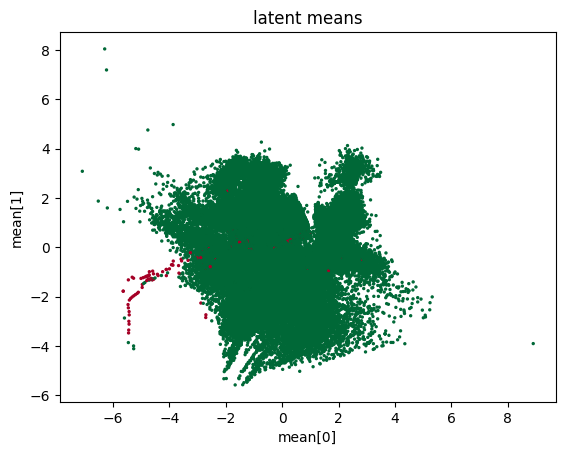

In [56]:
# Results after 100
# See para 3.2 for x and y
# 3.2
"""
x = data.drop(["Class"], axis=1)
y = data["Class"].values
"""

latent_x_mean = variational_encoder(x.values)[0].numpy()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

In [ ]:
################